# Corporación Favoritas Sales Analysis


## Background
Corporación Favorita is a large grocery retailer based in Ecuador. I am asked to predict sales for thousands of products sold at Favorita stores.

https://www.corporacionfavorita.com/

## Data Preparation
data cleaning

date from 12-31-2012 to 08-14-2017

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

In [3]:
# parsing the date columns
train = pd.read_csv(
    'store_sales_data/train.csv',
    index_col='id',
    parse_dates=['date']
)

holidays_events = pd.read_csv(
    'store_sales_data/holidays_events.csv',
    parse_dates=['date']
)

stores = pd.read_csv(
    'store_sales_data/stores.csv',
    index_col='store_nbr'
)

transactions = pd.read_csv(
    'store_sales_data/transactions.csv',
    parse_dates=['date']
)

oil = pd.read_csv(
    'store_sales_data/oil.csv',
    parse_dates=['date']
)

train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


### Conceptualize
1. identify grain, measures, & dimensions

    a. what does each row  represent?

    b. quantitative vs qualitative & which is most relevant for the task

    c. proper number formatting & consistent categories

2. identify critical & non-critical cols
- which columns _must_ be high quality (>80% complete accurate) for this analysis? Which are unimportant?

3. Understand definitions of critical columns
- which columns are important and what does each mean?
- be able to explain each important column in plain English
- state date range

#### train

In [4]:
train.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [5]:
train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

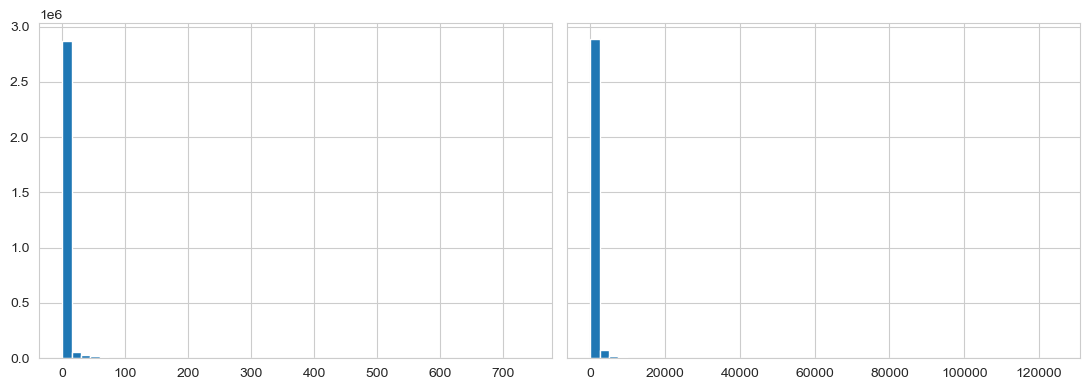

In [6]:
fig,(ax1,ax2) = plt.subplots(ncols=2,sharey=True)
ax1.hist('onpromotion',data=train,bins=50)
ax2.hist(x='sales',data=train,bins=50)
plt.show()

**Grain:** For the `train` table, each row represents the number of units of a product sold (`sales`) and total number of items for promotion (`onpromotion`) for a specific store (`store_nbr`) and type of product sold (`family`) on a given day. `family` is repeated for each `store_nbr` such that each day has all combinations of both.

**Critical columns?:** As far as I can tell, every column is important for this analysis. `onpromotion` has the possibility of not being as useful. However, I doubt this; the `sales` and `onpromotion` columns have very similar distributions, with the vast majority being at 0.


**Definition of critical columns:** 
- `date` is a self-explanatory quantitative variable. This might need to be augmented to a pandas datetime object. The date range is between 01-01-2013 to 08-15-2017.
- `store_nbr` is an int64 object, which is quantitative and is the proper number formatting as it is an id that connects to the `stores` table.
- `family` is of type object and is qualitative. Eyeballing the data, the categories look consistent.
- `sales` is the total sales and can have decimal places as a float object since products can be sold fractionally (e.g., 1.5 kg of cheese). This is the most important column and the object of our forecasting.
- `onpromotion` is the total number of items being promoted and is an integer object.

#### holidays_events

In [7]:
holidays_events.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


Validating if `holidays_events` table's locale names of localee type 'Local' are equivalent to the `store` table's cities, and locale type 'Regional'are equivalent to 'state'. And of course, Ecuador is at the 'National' locale type.

In [8]:
# if any values returned from this query, 'Local' is not at the city level
holidays_events[
    (~holidays_events['locale_name'].isin(stores.city.unique()) 
     & (holidays_events['locale']=='Local'))
]['locale_name'].unique()

array([], dtype=object)

In [9]:
# if any values returned, 'Regional' is not at the province/state level
holidays_events[
    (~holidays_events['locale_name'].isin(stores.state.unique()) 
     & (holidays_events['locale']=='Regional'))
]['locale_name'].unique()

array([], dtype=object)

Ok, so we know now that the 'Local' locale types are cities and the 'Regional' locale types are provinces (or  states in the stores table--see stores section below to confer).

In [10]:
holidays_events.type.value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

##### Additional

In [11]:
holidays_events[holidays_events.description.isin(['Navidad','Navidad-1'])][:4]

,date,type,locale,locale_name,description,transferred
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False
88,2013-12-24,Additional,National,Ecuador,Navidad-1,False
89,2013-12-25,Holiday,National,Ecuador,Navidad,False


Verified above, 'Holiday' and 'Event' types are self-explanatory, however Events are only provided here at the National level. An 'Additional' type extends its given holiday for the specified day and appends "-<# of the additional day starting with 1>", e.g., 'Navidad-1' for additional days for 'Navidad'.

##### Transfer

'Transfer' coincides with holidays that were transferred (i.e., its corresponding holiday/event has 'True' values in the `transferred` column):

In [12]:
holidays_events[holidays_events.type=='Transfer'][2:5]

,date,type,locale,locale_name,description,transferred
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False


However, the `description` is appended with 'Traslado ', meaning transfer, which may make finding the corresponding holiday cumbersome. I'm unsure if I should consider removing the 'Traslado ' or if this is bad for the analyses I'd like to conduct.

##### Bridge

For type 'Bridge', prefixed with 'Puente ', these are extensions to Holidays/Events to make a long weekend; we see that these are either on Friday or Sunday, and that they are similar to type 'Additional' days and can even overlap:

In [13]:
for i in holidays_events[holidays_events['type']=='Bridge']['date']:
    print(pd.to_datetime(i).weekday())

0
0
4
4
4


In [14]:
holidays_events[holidays_events['date']=='2014-12-26']

,date,type,locale,locale_name,description,transferred
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
157,2014-12-26,Additional,National,Ecuador,Navidad+1,False


##### Workday 

Finally, the last type 'Work Day' represents the days not normally scheduled for work (e.g., Saturday) to compensate the bridge days. These days do not have to be close to one another (e.g., 'Recupero puente primer dia del ano' is on '2013-01-12' while the day it's replacing 'Puente Primer dia del ano' is on '2013-01-12'):

In [15]:
for i in holidays_events[holidays_events['type']=='Work Day']['date']:
    print(pd.to_datetime(i).weekday())

5
5
5
5
5


In [16]:
holidays_events[holidays_events['date'].isin(['2013-01-12','2012-12-31'])]

C:\Users\jesse\AppData\Local\Temp\ipykernel_17968\2285221492.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  holidays_events[holidays_events['date'].isin(['2013-01-12','2012-12-31'])]


,date,type,locale,locale_name,description,transferred
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False


##### Issues with Categories

I must consider making these descriptions all lower case or upper case if I use regex, as there are inconsistencies in the spelling (e.g., on '2013-01-12', 'Recupero puente primer dia del ano' differs from the corresponding 'Puente Primer dia del ano' in that 'Puente Primer' are both capitalized in the latter but not the former).

It seems redundant to keep both the appended characters AND the `type` column. Not sure if it's better to keep or remove them.

**Grain:** For the `holidays_events` table, each row represents the holiday or event's name (`description`),  `date`, and locale level where observed (`locale`; i.e., National, Regional, Local) and the name of the specific country (obviously Ecuador), province, or city (`locale_name`). For example, 'Puente Navidad' was a bridge holiday observed on '2014-12-26' in all Ecuador, which is at the 'National' locale level. 

**Critical Columns?:** I believe the `date`, `locale`, `locale_name`, `description`, and `transferred` columns are the most obviously important. As stated above in my observations, there seems to be redundancy since since the `type` column is encoded in the `description` column with its appendings. I think it is a very important column. We can keep both, or I propose either:

1. removing the `type` column and keeping the appendings
2. keeping the `type` column but removing the appendings (with regex?)

**Definition of Critical Columns:** 
- `date` is a self-explanatory quantitative variable. It may need to be augmented to a pandas datetime object.
- `type` is the type of holiday or event observed and is a qualitative variable with the categories Holiday, Event, Additional, Transfer, Bridge, and Work Day.
- `locale` is the locale level and can be National (Country of Ecuador), Regional (Province/State), or Local (City).
- `locale_name` is the name of the specific Country, Province (State), or City.
- `description` is the name of the holiday or event. See above sections for more detailed explanations of categories. **Prefixes/Suffix:**
    - Additional (suffix, not prefix) - '-1', '-2', ... '-*n*'
    - Transfer - 'Traslado '
    - Bridge - 'Puente '
    - Work Day - 'Recupero Puente ' | 'Recupero puente '
- `transferred` denotes if the holiday or event was transferred to another day and is represented by a boolean value of True or False





#### stores

In [17]:
stores.head(3)

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8


In [18]:
print(len(stores.city.unique())),
stores.city.unique()

22


array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [19]:
print(len(stores.state.unique()), 'provinces included in this dataset'),
stores.state.unique()

16 provinces included in this dataset


array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

Verifying with [Wikipedia](https://en.wikipedia.org/wiki/Provinces_of_Ecuador), 'states' in the `stores` table refer to the provinces of Ecuador. Likewise, 'cities' are cities. I was considering removing this column as many are simply the capital cities of their respective provinces, however not all of them are (e.g., Salinas) so it does provide additional information.


I might consider augmentation by using region codes instead for consistency.

In [20]:
# https://stackoverflow.com/questions/22412033/python-pandas-pivot-table-count-frequency-in-one-column/52906833#52906833
pd.pivot_table(
    data=stores,
    index=['type','cluster'],
    aggfunc='size'
)

type  cluster
A     5          1
      11         3
      14         4
      17         1
B     6          6
      10         1
      16         1
C     3          7
      7          2
      12         1
      15         5
D     1          3
      2          2
      4          3
      8          3
      9          2
      10         1
      13         4
E     10         4
dtype: int64

- Very close to identifying a hierarchy, with `type` being lower-grain over `cluster`. However, cluster 10 is repeated over E, D, and B; I would have to identify a pattern here, if any, otherwise we keep as is.
- Consider using region codes in place of city/province
- For the `store_nbr` col: can be joined with the `train` table. I might consider augmenting it to be the index of the dataframe.
- According to the documentation, `cluster` is a grouping of similar stores. Does this imply that `type` is more arbitrary? It's hard to know for certain

**Grain:** For the `stores` table, each row represents a store identified by `store_nbr` with its city and province (`state`) as well as its group in the `type` and `cluster` columns.

**Critical Columns?:** For now, we assume all the columns are critical until further investigation. The two columns that I am most doubtful for are the `type` and `cluster` columns, which I believe should give the relationship to other stores and should add an additional layer of information beyond location, although I cannot be certain.So, let's keep these for now.

**Definition of Critical Columns:**
- `store_nbr` functions as the id or index of the `stores` table. 
- `city` is the qualitative variable representing the particular city
- `state` represents the particular province within Ecuador and is also a qualitative variable
- `type` and `cluster` are a bit ambiguous, as noted above. Both are qualitative variables.

#### transactions

In [21]:
transactions.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


**Grain:** Each row of the `transactions` table represents the number of transactions on a given day for a given store.

**Critical Column?:** I suppose every column is an important column here. Plus, this is a small table.

**Definition of Critical Column:**
- `date` is self-explanatory.
- `store_nbr` is a store identification int64 quantitative variable, to join with the `stores` table.
- `transactions` is, presumably, the number of transactions, as the documentation does not include this table.

#### oil

In [22]:
oil.head(3)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


- I must determine the currency of the `oil` table used for oil pricing. This is crucial as there is a significant difference between peso and dollar

**Grain:** Each row of the `oil` table represents the daily oil price on a given day.

**Critical Column?:** These two columns might be useful in the analysis. They are of moderate importance and can try to be used.

**Description of Important Columns:**
- `date` is the same as every other table...
- `dcoilwtico` is the daily oil price, although the documentation never specifies which currency.

### Locate
1. Formatting
    - consistent number and date formats
    - in pandas, it's expected for strings to be object dtype: https://stackoverflow.com/questions/34881079/pandas-distinction-between-str-and-object-types
2. Consistency
    - spelling & spacing, categorization differences,
3. Duplicates
    - eyeball the data
    - pivot tables or groupbys
    - window functions

#### train

In [23]:
train.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [24]:
DATE_RANGE = pd.date_range('01-01-2013','08-15-2017')

print('Missing dates:', len(DATE_RANGE) - len(train['date'].unique()))
DATE_RANGE.difference(train['date'])

Missing dates: 4


DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [25]:
# for i in (train['store_nbr'].value_counts()!=55572):
#     if i:
#         print(i)

vc = train.store_nbr.value_counts()
vc[vc!=55572]

Series([], Name: count, dtype: int64)

In [26]:
for i in (train["family"].value_counts()!=90936):
    if i:
        print(i)

In [27]:
pt = pd.pivot_table(
    data=train,
    values='sales',
    index=['store_nbr','family'],
    aggfunc="count"
)
pt

sales
store_nbr family                           
1         AUTOMOTIVE                   1684
          BABY CARE                    1684
          BEAUTY                       1684
          BEVERAGES                    1684
          BOOKS                        1684
...                                     ...
54        POULTRY                      1684
          PREPARED FOODS               1684
          PRODUCE                      1684
          SCHOOL AND OFFICE SUPPLIES   1684
          SEAFOOD                      1684

[1782 rows x 1 columns]

In [28]:
pt[pt['sales']!=1684]

,,sales
store_nbr,family,


In [29]:
train.sales.describe()

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

In [30]:
train.onpromotion.describe()

count    3.000888e+06
mean     2.602770e+00
std      1.221888e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.410000e+02
Name: onpromotion, dtype: float64

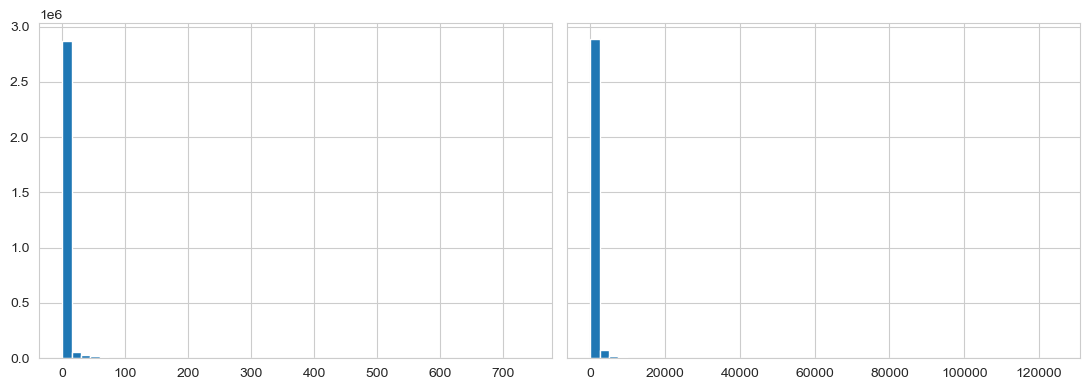

In [31]:
fig,(ax1,ax2) = plt.subplots(ncols=2,sharey=True)
ax1.hist('onpromotion',data=train,bins=50)
ax2.hist(x='sales',data=train,bins=50)
plt.show()

In [32]:
train[train.duplicated()]

,date,store_nbr,family,sales,onpromotion
id,,,,,


**Formatting:** `date` column is correctly parsed, `store_nbr` and `onpromotion` are correctly int64, `family` is correctly a pandas object, and `sales` is correctly a float64.

**Consistency:**
- `date` has 4 missing dates. On inspection, the stores close every year for Christmas (12/25).
- `store_nbr` has 55,572 values per store, `family` has 90,936 values per product type, and `sales` has 1684 values per store and family, so consistency holds for these.
- `sales` and `onpromotion` are very interesting as they are very 0-value heavy with very high values. Is there a possibility these could be outliers or incorrect? Not sure, but the max values are 124,717.0 for sales and 741.0 for onpromotion. The distribution is definitely interesting here.

**Duplicates:** There are no duplicates.

#### holidays_events

In [33]:
holidays_events.dtypes

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [34]:
holidays_events.type.value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [35]:
holidays_events.locale.value_counts()

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

In [36]:
print(np.sort(holidays_events.locale_name.unique()))

['Ambato' 'Cayambe' 'Cotopaxi' 'Cuenca' 'Ecuador' 'El Carmen' 'Esmeraldas'
 'Guaranda' 'Guayaquil' 'Ibarra' 'Imbabura' 'Latacunga' 'Libertad' 'Loja'
 'Machala' 'Manta' 'Puyo' 'Quevedo' 'Quito' 'Riobamba' 'Salinas'
 'Santa Elena' 'Santo Domingo' 'Santo Domingo de los Tsachilas']


In [37]:
print(np.sort(holidays_events.description.unique()))

['Batalla de Pichincha' 'Black Friday' 'Cantonizacion de Cayambe'
 'Cantonizacion de El Carmen' 'Cantonizacion de Guaranda'
 'Cantonizacion de Latacunga' 'Cantonizacion de Libertad'
 'Cantonizacion de Quevedo' 'Cantonizacion de Riobamba'
 'Cantonizacion de Salinas' 'Cantonizacion del Puyo' 'Carnaval'
 'Cyber Monday' 'Dia de Difuntos' 'Dia de la Madre' 'Dia de la Madre-1'
 'Dia del Trabajo' 'Fundacion de Ambato' 'Fundacion de Cuenca'
 'Fundacion de Esmeraldas' 'Fundacion de Guayaquil'
 'Fundacion de Guayaquil-1' 'Fundacion de Ibarra' 'Fundacion de Loja'
 'Fundacion de Machala' 'Fundacion de Manta' 'Fundacion de Quito'
 'Fundacion de Quito-1' 'Fundacion de Riobamba'
 'Fundacion de Santo Domingo' 'Inauguracion Mundial de futbol Brasil'
 'Independencia de Ambato' 'Independencia de Cuenca'
 'Independencia de Guaranda' 'Independencia de Guayaquil'
 'Independencia de Latacunga' 'Mundial de futbol Brasil: Cuartos de Final'
 'Mundial de futbol Brasil: Ecuador-Francia'
 'Mundial de futbol Brasil

In [38]:
holidays_events.transferred.value_counts()

transferred
False    338
True      12
Name: count, dtype: int64

In [39]:
# count the number of event by locale and type of event
pd.pivot_table(
    data=holidays_events,
    index=['locale','locale_name'],
    columns='type',
    aggfunc='size',
    fill_value=0
)

type                                     Additional  Bridge  Event  Holiday  \
locale   locale_name                                                          
Local    Ambato                                   0       0      0       12   
         Cayambe                                  0       0      0        6   
         Cuenca                                   0       0      0        6   
         El Carmen                                0       0      0        6   
         Esmeraldas                               0       0      0        6   
         Guaranda                                 0       0      0       12   
         Guayaquil                                5       0      0        5   
         Ibarra                                   0       0      0        6   
         Latacunga                                0       0      0       12   
         Libertad                                 0       0      0        6   
         Loja                                     0       0      0        6   
         Machala                                  0       0      0        6   
         Manta                                    0       0      0        6   
         Puyo                                     0       0      0        6   
         Quevedo                                  0       0      0        6   
         Quito                                    6       0      0        6   
         Riobamba                                 0       0      0       12   
         Salinas                                  0       0      0        6   
         Santo Domingo                            0       0      0        6   
National Ecuador                                 40       5     56       60   
Regional Cotopaxi                                 0       0      0        6   
         Imbabura                                 0       0      0        6   
         Santa Elena                              0       0      0        6   
         Santo Domingo de los Tsachilas           0       0      0        6   

type                                     Transfer  Work Day  
locale   locale_name                                         
Local    Ambato                                 0         0  
         Cayambe                                0         0  
         Cuenca                                 1         0  
         El Carmen                              0         0  
         Esmeraldas                             0         0  
         Guaranda                               0         0  
         Guayaquil                              1         0  
         Ibarra                                 1         0  
         Latacunga                              0         0  
         Libertad                               0         0  
         Loja                                   0         0  
         Machala                                0         0  
         Manta                                  0         0  
         Puyo                                   0         0  
         Quevedo                                0         0  
         Quito                                  1         0  
         Riobamba                               0         0  
         Salinas                                0         0  
         Santo Domingo                          0         0  
National Ecuador                                8         5  
Regional Cotopaxi                               0         0  
         Imbabura                               0         0  
         Santa Elena                            0         0  
         Santo Domingo de los Tsachilas         0         0

In [40]:
holidays_events[holidays_events.duplicated()]

,date,type,locale,locale_name,description,transferred


**Formatting:** All data types are correct. Transferred is correctly a Boolean value.

**Consistency:** 
- Pandas objects: `type`, `locale`, `locale_name`, and `description` all have no spelling, spacing, or categorization differences.
- `transferred` correctly has only 12 True values; as shown in the previous section, this maps to the holiday/event type "transferred" and has a corresponding value there.

**Duplicates:** There are no duplicates.

#### stores

In [41]:
stores.dtypes

city       object
state      object
type       object
cluster     int64
dtype: object

In [42]:
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [43]:
for i in np.sort(stores.city.unique()):
    print(i)

Ambato
Babahoyo
Cayambe
Cuenca
Daule
El Carmen
Esmeraldas
Guaranda
Guayaquil
Ibarra
Latacunga
Libertad
Loja
Machala
Manta
Playas
Puyo
Quevedo
Quito
Riobamba
Salinas
Santo Domingo


In [44]:
for i in np.sort(stores.state.unique()):
    print(i)

Azuay
Bolivar
Chimborazo
Cotopaxi
El Oro
Esmeraldas
Guayas
Imbabura
Loja
Los Rios
Manabi
Pastaza
Pichincha
Santa Elena
Santo Domingo de los Tsachilas
Tungurahua


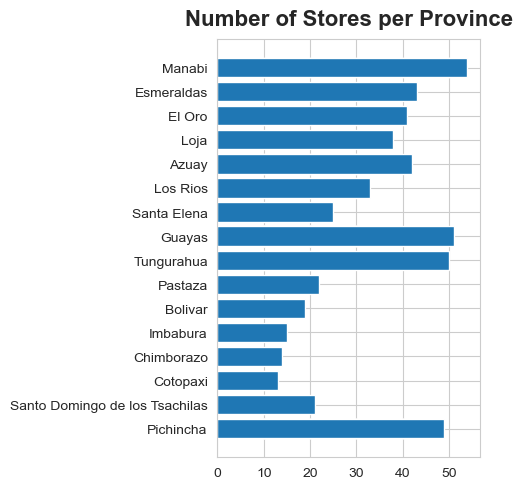

In [45]:
fig,ax = plt.subplots(figsize=(5,5))
ax.barh('state','store_nbr',data=stores.reset_index())
ax.set_title('Number of Stores per Province')
plt.show()

In [46]:
stores.type.value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

In [47]:
print("Number of stores:", len(stores.cluster))
stores['cluster'].value_counts()
# plt.plot()

Number of stores: 54


cluster
3     7
10    6
6     6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
2     2
9     2
7     2
12    1
16    1
5     1
17    1
Name: count, dtype: int64

In [48]:
pd.pivot_table(
    data=stores,
    index=['state','city','type','cluster'],
    aggfunc="size",
    sort=True
)

state                           city           type  cluster
Azuay                           Cuenca         B     6          1
                                               D     2          2
Bolivar                         Guaranda       C     15         1
Chimborazo                      Riobamba       C     7          1
Cotopaxi                        Latacunga      C     15         2
El Oro                          Machala        C     3          1
                                               D     4          1
Esmeraldas                      Esmeraldas     E     10         1
Guayas                          Daule          D     1          1
                                Guayaquil      A     17         1
                                               B     6          1
                                               C     3          2
                                               D     1          1
                                                     10         1
               

In [49]:
stores[stores.duplicated()]

,city,state,type,cluster
store_nbr,,,,
2,Quito,Pichincha,D,13
6,Quito,Pichincha,D,13
7,Quito,Pichincha,D,8
8,Quito,Pichincha,D,8
13,Latacunga,Cotopaxi,C,15
20,Quito,Pichincha,B,6
29,Guayaquil,Guayas,E,10
32,Guayaquil,Guayas,C,3
42,Cuenca,Azuay,D,2


**Formatting:** All data types are correct, except for `cluster`. While it is indeed a number, it must be converted to an object to avoid confusion in the analysis and a false ordering.

**Consistency:** 
- Pandas objects: `city`, `state`, and `type` all have consistent spelling, spacing, and categorization.
- `cluster` is a qualitative value, despite being of type int64. Therefore, must be changed to an object.

**Duplicates:** There are no duplicates.

#### transactions

In [50]:
transactions.dtypes

date            datetime64[ns]
store_nbr                int64
transactions             int64
dtype: object

In [51]:
DATE_RANGE.difference(transactions.date.unique())

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-01-01',
               '2016-01-03', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)

In [52]:
transactions[transactions.date=='2016-01-01']

,date,store_nbr,transactions


In [53]:
train[(train.date=='2016-01-01') & (train.sales > 0)]

,date,store_nbr,family,sales,onpromotion
id,,,,,
1946505,2016-01-01,25,AUTOMOTIVE,4.000,0
1946507,2016-01-01,25,BEAUTY,13.000,0
1946508,2016-01-01,25,BEVERAGES,5104.000,1
1946510,2016-01-01,25,BREAD/BAKERY,680.952,0
1946511,2016-01-01,25,CELEBRATION,13.000,0
1946512,2016-01-01,25,CLEANING,734.000,0
1946513,2016-01-01,25,DAIRY,1033.000,11
1946514,2016-01-01,25,DELI,295.181,47
1946515,2016-01-01,25,EGGS,230.000,24


In [54]:
train[(train.date=='2016-01-03') & (train.sales > 0)]

,date,store_nbr,family,sales,onpromotion
id,,,,,
1949508,2016-01-03,1,AUTOMOTIVE,1.000,0
1949510,2016-01-03,1,BEAUTY,2.000,0
1949511,2016-01-03,1,BEVERAGES,1048.000,1
1949513,2016-01-03,1,BREAD/BAKERY,138.275,1
1949514,2016-01-03,1,CELEBRATION,5.000,0
...,...,...,...,...,...
1951285,2016-01-03,9,POULTRY,748.386,0
1951286,2016-01-03,9,PREPARED FOODS,143.022,0
1951287,2016-01-03,9,PRODUCE,3015.563,0


There are clearly values here in `train` on these two days that do not appear in `transactions`.

In [55]:
pt = pd.pivot_table(
    data=train,
    values='sales',
    index=['date','store_nbr'],
    aggfunc='sum'
)

tt = pt.merge(
    right=transactions,
    how='right',
    on=['date','store_nbr']
)

tt.head()

,date,store_nbr,sales,transactions
0,2013-01-01,25,2511.618999,770
1,2013-01-02,1,7417.148000,2111
2,2013-01-02,2,10266.718981,2358
3,2013-01-02,3,24060.348000,3487
4,2013-01-02,4,10200.083980,1922


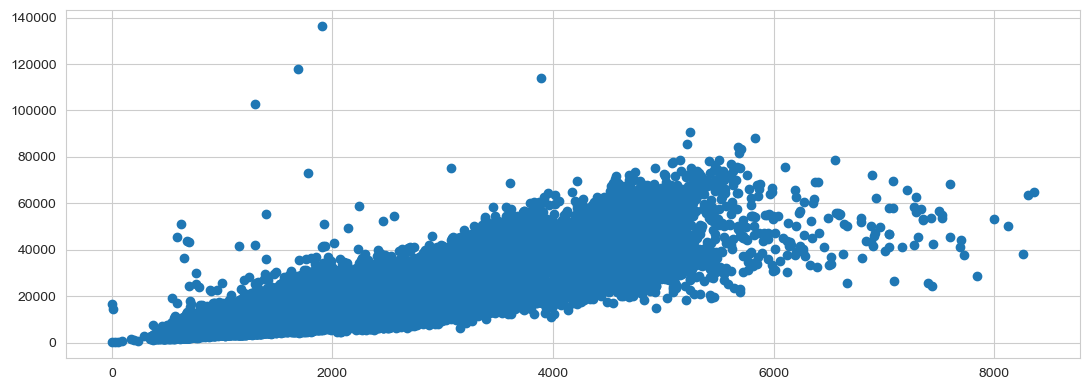

In [56]:
plt.scatter(data=tt,x='transactions',y='sales')
plt.show()

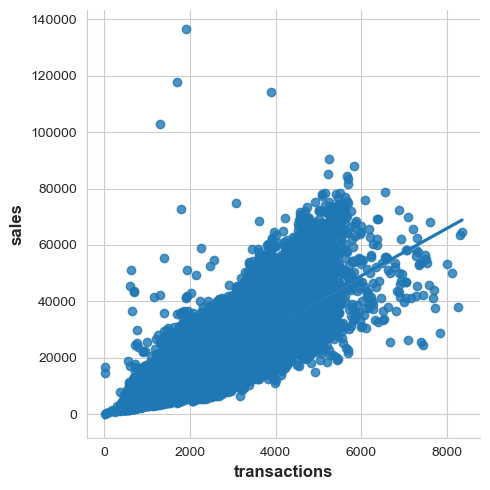

In [57]:
sns.lmplot(
    data=tt,
    x='transactions',
    y='sales'
)
plt.show()

In [58]:
pt1 = pd.pivot_table(
    data=transactions,
    values='transactions',
    index=['date'],
    aggfunc='sum'
)
pt1

,transactions
date,
2013-01-01,770
2013-01-02,93215
2013-01-03,78504
2013-01-04,78494
2013-01-05,93573
...,...
2017-08-11,89551
2017-08-12,89927
2017-08-13,85993


In [59]:
pt = pd.pivot_table(
    data=train,
    values='sales',
    index=['date'],
    aggfunc='sum'
)
pt

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


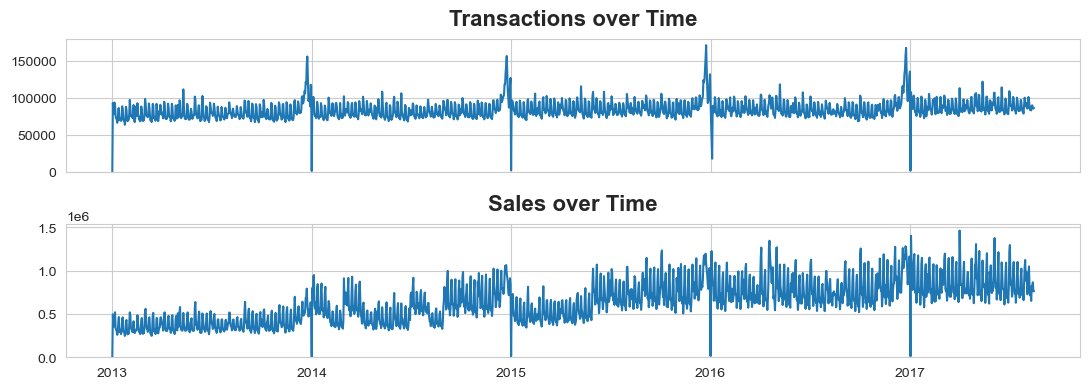

In [60]:
fig,(ax1,ax2) = plt.subplots(nrows=2,sharex=True)

ax1.plot(pt1.index,pt1.transactions)
ax1.set_title('Transactions over Time')
ax1.set_ylim(0)

ax2.plot(pt.index,pt.sales)
ax2.set_title('Sales over Time')
ax2.set_ylim(0)
plt.show()

In [61]:
pt = pd.pivot_table(
    data=transactions,
    values='transactions',
    index=['date','store_nbr'],
    aggfunc='sum',
    fill_value=0
)
pt

transactions
date       store_nbr              
2013-01-01 25                  770
2013-01-02 1                  2111
           2                  2358
           3                  3487
           4                  1922
...                            ...
2017-08-15 50                 2804
           51                 1573
           52                 2255
           53                  932
           54                  802

[83488 rows x 1 columns]

In [62]:
print("Expected number of transactions:", len(DATE_RANGE))
print("Expected sales:",len(DATE_RANGE) * len(train.family.unique()))

Expected number of transactions: 1688
Expected sales: 55704


In [63]:
gb = train.groupby(['date','store_nbr'], as_index=False)["sales"].sum()
gb

,date,store_nbr,sales
0,2013-01-01,1,0.000000
1,2013-01-01,2,0.000000
2,2013-01-01,3,0.000000
3,2013-01-01,4,0.000000
4,2013-01-01,5,0.000000
...,...,...,...
90931,2017-08-15,50,16879.121004
90932,2017-08-15,51,20154.559000
90933,2017-08-15,52,18600.046000
90934,2017-08-15,53,8208.189000


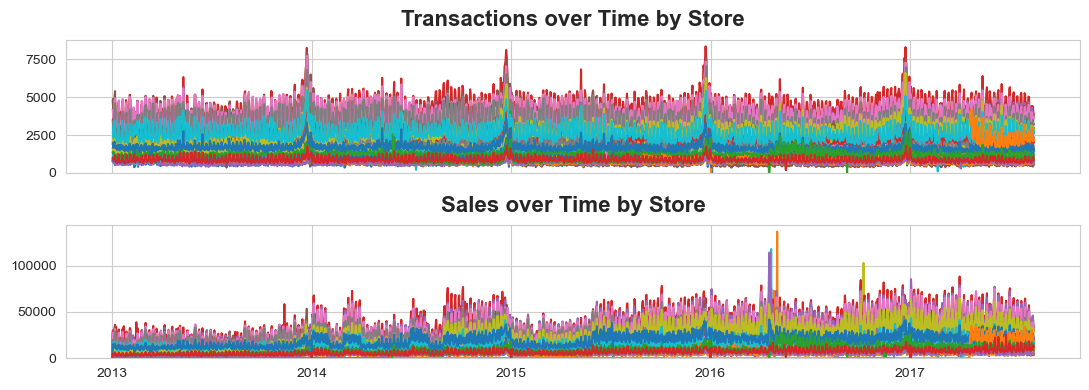

In [64]:
fig,(ax1,ax2) = plt.subplots(nrows=2, sharex=True)

for store, group in transactions.groupby('store_nbr'):
    ax1.plot(
        group['date'],
        group['transactions'],
        label=f"Store {store}"
    )
for store, group in gb.groupby('store_nbr'):
    ax2.plot(
        group['date'],
        group['sales'],
        label=f"Store {store}"
    )
# plt.ylabel("Number of Transactions")
ax1.set_title("Transactions over Time by Store")
ax2.set_title("Sales over Time by Store")
# ax2.legend(title="Store Number", bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.grid(True,which='minor')
ax1.set_ylim(0)
ax2.set_ylim(0)
# Show plot
plt.show()

In [65]:
transactions[transactions.duplicated()]

,date,store_nbr,transactions


**Formatting:** All data types are correct. `store_nbr` must remain an integer to join with the `stores` table index, even though it is not meaningfully categorical.

**Consistency:** 
- the missing `date` values match those missing in `train` (Christmas), however there are also no transactions on '2016-01-01' and '2016-01-03'. On further investigation, clearly there are sales in the 	train` table for both dates. Either something is wrong with the transactions table, or my operational definition is wrong. Maybe transactions do not represent sales but something else that we don't know about.
- there appears to be a relationship between `transaction` and `sales`; when making a scatter plot sliced by each date and store_nbr, aggregated by the totals, there seems to be a strong positive correlation. We can investigate in later analyses.

**Duplicates:** There are no duplicates.

#### oil

In [66]:
oil.dtypes

date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [67]:
oil.dcoilwtico.describe()

count    1175.000000
mean       67.714366
std        25.630476
min        26.190000
25%        46.405000
50%        53.190000
75%        95.660000
max       110.620000
Name: dcoilwtico, dtype: float64

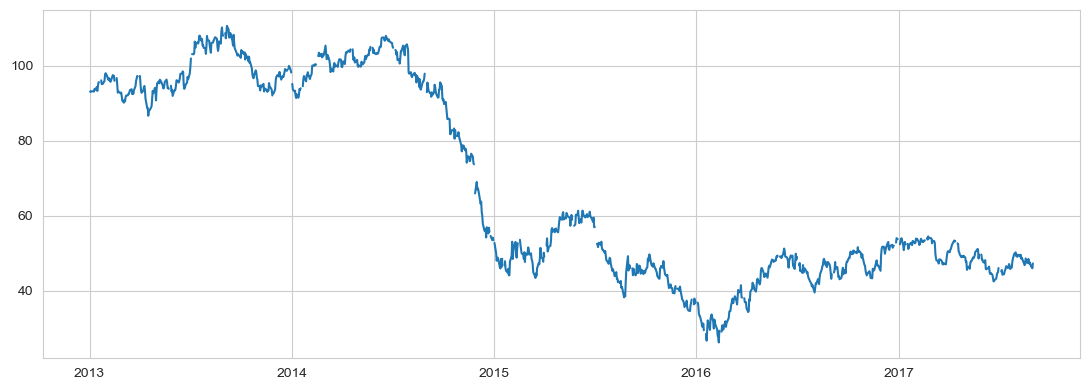

In [68]:
fig,ax = plt.subplots()

ax.plot('date','dcoilwtico',data=oil)
plt.show()

In [69]:
DATE_RANGE.difference(oil.date)

DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-15', '2017-07-16', '2017-07-22', '2017-07-23',
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13'],
              dtype='datetime64[ns]', length=482, freq=None)

In [70]:
print("Percent of missing dates:", (len(DATE_RANGE) - len(oil)) / len(DATE_RANGE))

Percent of missing dates: 0.278436018957346


In [71]:
oil[oil.duplicated]

,date,dcoilwtico


**Formatting:** All formats are correct.

**Consistency:** There are 27.84% of missing dates in the `oil` table. Looking at https://fred.stlouisfed.org/series/DCOILWTICO/, this is because they skip weekends or US Holidays (e.g., Christmas, July 4th, New Year's Day)

**Duplicates:** There are no duplicates.

### Evaluate
1. Missing data
2. Nonsensical data

Benchmark! Calculate magnitude (% impact) of issue
- \>30% missing or nonsense: column likely unusable, or find another source
- few records missing (<10%): likely keep data as is
- 70-90% missing, make judgment
    - leave data as is
    - impute
    - exclude
- document thought process

#### transactions

`transactions` table is only missing 6 dates out of the entire dates collection

In [72]:
DATE_RANGE.difference(transactions.date.unique())

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-01-01',
               '2016-01-03', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)

#### oil

The `oil` table is missing about 27% of the dates. It is not over 30%, which means we can still possibly include it somehow, although I'm not sure how. It would likely be useful as Ecuador is dependent on oil with an economy vulnerable to oil price shocks.

## Business Use Cases and Data Requirements

Admittedly, this section should have gone before Data preparation.

In [73]:
len(train.family.unique())

33

### Question Ideas
1. **Overall trends**: What are the overall sales trends across different product families during this period?
    - **Seasonality**: Are there seasonal patterns in sales, and how do they compare to previous periods?
    - **Dimensionality**: How do sales vary across different store clusters and locations?
    - How do holidays and special events impact sales across different stores and product categories?
    - How do oil price fluctuations correlate with overall sales trends?    
2. **Growth rates**: What are our month-over-month and year-over-year sales growth rates?
    - **Seasonality**: How has the number of promoted items changed over time, and how does that impact growth?
    - **Dimensionality**: 
        - Which product families have shown the highest and lowest growth in sales?
        - How has the number of promoted items changed over time, and how does that impact growth?
    - Has sales growth differed on holiday vs. non-holiday periods?
    - **Distribution**: Which product families have shown the highest and lowest growth in sales?
3. **Performance measurement**: How do the number of items on promotion drive sales up or down?
	- **Dimensionality**: 
        - How are different stores/types/clusters promoting their inventory? How does the effectiveness of promotions vary across different store types and locations?
        - How do promotions impact total sales volume across different product categories?
        - Which product families benefit the most from promotions in terms of sales increase?
    - **Seasonality**: Do promotions lead to an increase in overall revenue, or do they mainly shift sales between time periods?
    - **Distribution**: Are there any instances where promotions did not lead to a significant increase in sales?
4. **KPI reporting**: see business metrics notes
    - **Distribution**: What are the top-performing stores and product families based on total sales?
    - **Summary Stats**: 
        - What is the average revenue per store and per product family?
        - What is the average number of promoted items per store, and how does it correlate with sales?
    - How does the sales per store compare against the expected forecast?
    - Which stores underperform compared to their cluster, and what factors may contribute to this?
    - What percentage of sales come from promoted items versus non-promoted items?


### Narrowing down

**How are sales currently? How effective are the promotions?**

1. **Overall trends**: What are the overall sales trends across different product families during this period? across store locations/clusters?
    - **Seasonality**: Are there seasonal patterns in sales, and how do they compare to previous periods?

2. **Growth rates**: What are our month-over-month and year-over-year sales growth rates?
	- Which product families have shown the highest and lowest growth in sales?
	- How has the number of promoted items changed over time, and how does that impact growth?

3. **Performance measurement**:  How do the number of items on promotion drive sales up or down?
	- **Dimensionality**: 
        - How are different stores/types/clusters promoting their inventory? How does the effectiveness of promotions vary across different store types and locations?
        - How do promotions impact total sales volume across different product categories?
        - Which product families benefit the most from promotions in terms of sales increase? Which holidays?
    - **Seasonality**: Do promotions lead to an increase in overall revenue, or do they mainly shift sales between time periods?
    - **Distribution**: Are there any instances where promotions did not lead to a significant increase in sales?

4. **KPI reporting**: 
	- What are the top-performing stores and product families based on total sales? Interactions with being promoted or not?
        - What is the average number of promoted items per store, and how does it correlate with sales?


## EDA

### 1. **Overall trends**: 
What are the overall sales trends across different product families during this period? across store locations/clusters?
- **Seasonality**: Are there seasonal patterns in sales, and how do they compare to previous periods?

Tables needed: `train`, `stores`, possibly `transactions`

See Below in Growth rates section. 

These observations come from the Family Quarter and Family MoM sheets on the Power BI.

**Observations**:

Looking at sales across families during the previous quarter for this year (2017) versus previous years, we can observe:
- Books are new in this quarter compared to the previous year, but have negative growth rates during this quarter as well as year-over-year (-44%)
    - If you look at a graph of sales filtered for books, the trend is very downward
- Grocery II appears to have a decent increase in sales growth rate in this quarter compared to previous years
- Decrease: Baby care, Celebration, Pet Supplies, Players and electronics, and Produce don't seem to have the same increased growth rate as in previous years
- Home care does not have as high an increase as previous years
- see below for year-over-year growth rates, giving more of a general picture

TYPES AND CLUSTERS (see "Type Performers" report)
- Type A has the highest average sales by far per store. What is making its performance so strong?
    - consists of the two highest-performing clusters, 5 and 11
    - clusters 14 and 17 are doing pretty well, too
- Type C has by far the lowest average sales per store, despite being the store type with the second-highest number of stores.
    - Even E, with the by far the lowest number of stores, has better average sales.
    - Clusters 15, 3, and 7 don't go above 300 in average sales. Cluster 12 is below 500

**Action**:
- Consider removing books from our product families?

In [74]:
(train[train['date']==train['date'].max()]
    .merge(stores['type'],'left',right_index=True,left_on='store_nbr')
    .groupby('type')['sales'].mean()
    )

type
A    742.304229
B    463.286492
C    286.604491
D    362.166135
E    476.469992
Name: sales, dtype: float64

In [75]:
train['date'].max()

Timestamp('2017-08-15 00:00:00')

In [103]:
# Filter for "School and Office Supplies"
school_supplies = train[train["family"] == "SCHOOL AND OFFICE SUPPLIES"]

# Aggregate sales and promotions by date
daily_sales = school_supplies.groupby("date").agg(
    {"sales": "sum", "onpromotion": "sum"}
).reset_index()

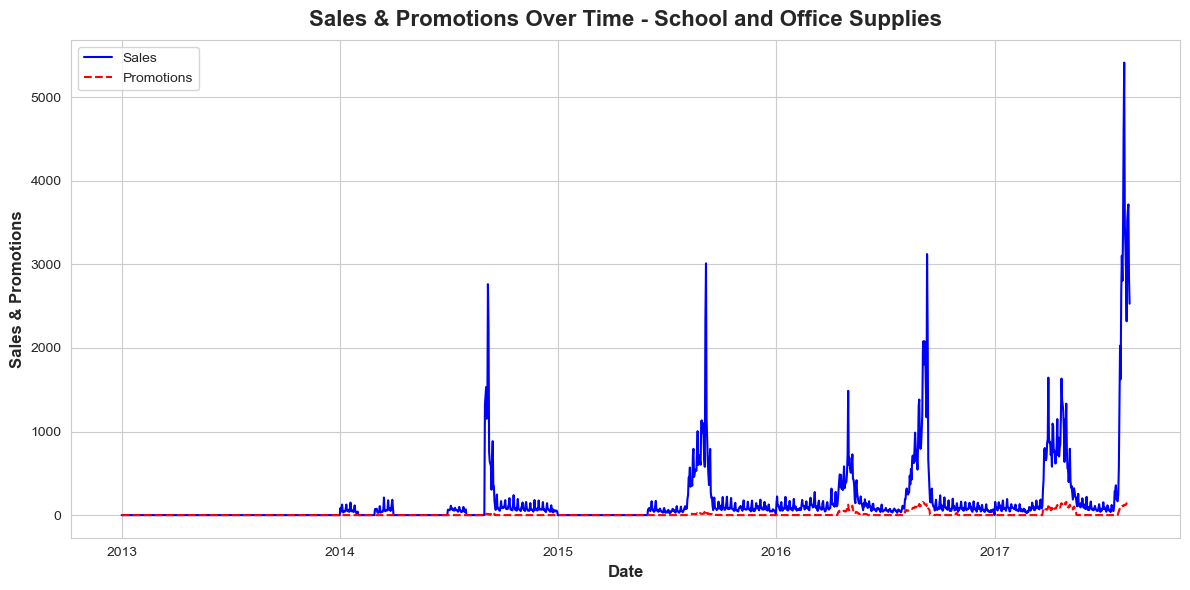

In [105]:
daily_sales["sales_before"] = daily_sales["sales"].shift(7)  # Sales 7 days before
daily_sales["sales_after"] = daily_sales["sales"].shift(-7)  # Sales 7 days after

plt.figure(figsize=(12,6))
plt.plot(daily_sales["date"], daily_sales["sales"], label="Sales", color="blue")
plt.plot(daily_sales["date"], daily_sales["onpromotion"], label="Promotions", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Sales & Promotions")
plt.legend()
plt.title("Sales & Promotions Over Time - School and Office Supplies")
plt.show()

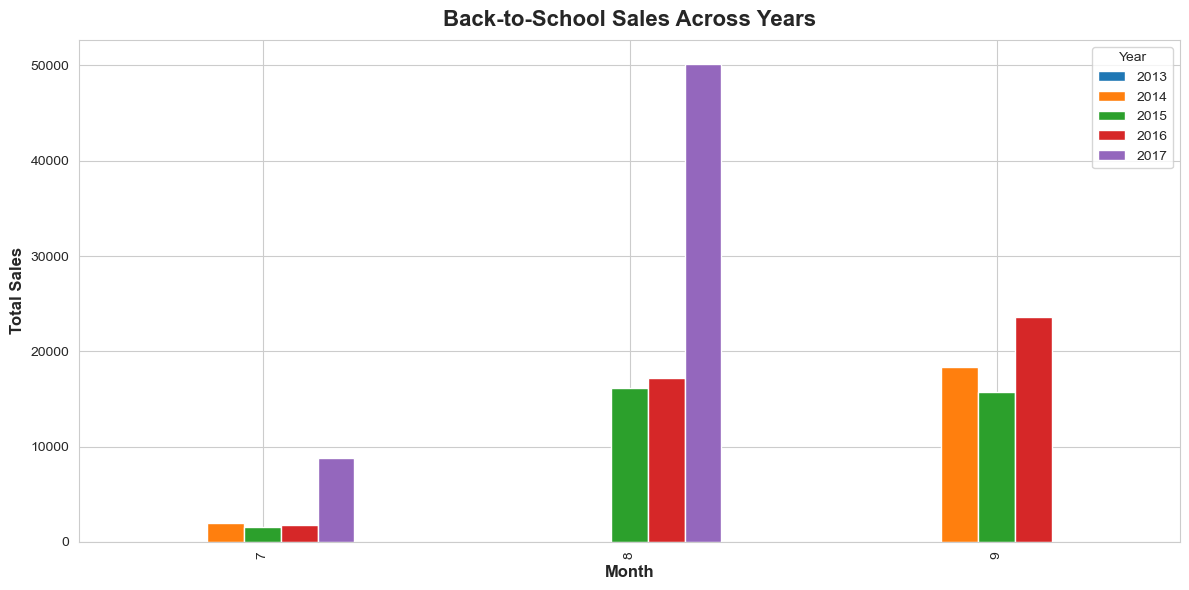

In [106]:
# Extract month and year
daily_sales["year"] = daily_sales["date"].dt.year
daily_sales["month"] = daily_sales["date"].dt.month

# Group by year and month to compare total sales during back-to-school season
monthly_sales = daily_sales.groupby(["year", "month"])["sales"].sum().unstack(0)

# Plot sales trends for back-to-school months (e.g., July-September)
monthly_sales.loc[[7, 8, 9]].plot(kind="bar", figsize=(12,6))
plt.title("Back-to-School Sales Across Years")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.legend(title="Year")
plt.show()

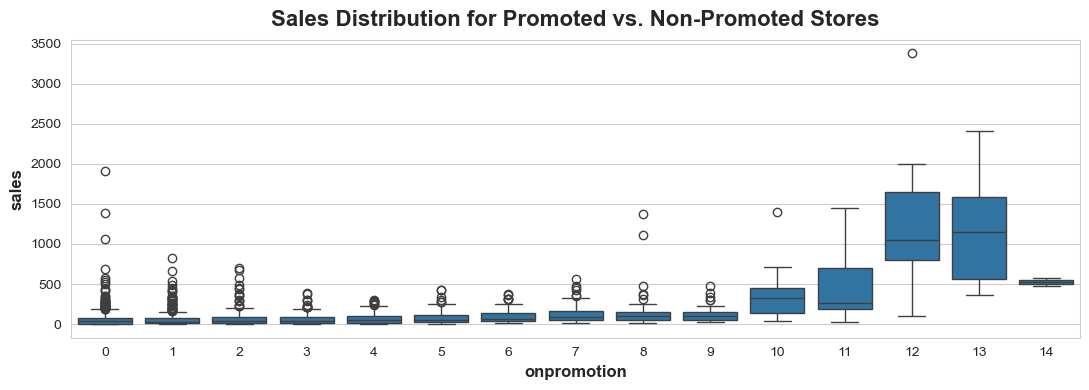

In [ ]:
# Merge store data
school_supplies = school_supplies.merge(stores, on="store_nbr")

# Compare sales between promoted and non-promoted stores
sales_by_promo = school_supplies.groupby(["date", "onpromotion"]).agg({"sales": "sum"}).reset_index()

sns.boxplot(x="onpromotion", y="sales", data=sales_by_promo)
plt.title("Sales Distribution for Promoted vs. Non-Promoted Stores")
plt.show()

In [108]:
# Calculate % drop after promotion
daily_sales["drop_after"] = (daily_sales["sales_after"] - daily_sales["sales"]) / daily_sales["sales"]

# Check if drop is significant
drop_median = daily_sales["drop_after"].median()
print(f"Median sales drop after promotion: {drop_median:.2%}")

Median sales drop after promotion: -2.31%


### 2. **Growth rates**: 
What are our month-over-month and year-over-year sales growth rates?
- Which product families have shown the highest and lowest growth in sales?
- How has the number of promoted items changed over time, and how does that impact growth?

See **Growth Rate** Sheet on the Power BI report. 

**Observations/follow-up questions & ideas**

OVERALL:
- Sales have seen positive increases in the year-over-year, as well as Transactions although at a much smaller rate. Items Promoted has seen the most dramatic increase.
- Sales and Transactions experience a 22% and 25% spike, respectively  in the final months (possibly from Christmas). This tends to return to normal rates around January or February.
    - How do holidays interact with this?
    - How should we define "Holiday Season"?

PRODUCT FAMILIES
- Top 10 highest in total sales:
    - Grocery I 
    - Beverages
    - Produce
    - Cleaning
    - Dairy
    - Bread/Bakery
    - Poultry
    - Meats
    - Personal Care
    - Deli
- Highest growth so far this year: Lawn and Garden (73%) - also highest in sales growth year-over-year
- Lowest: Frozen Foods (-53%) and Baby Care (-47%). However, Frozen Foods has enormous growth in December (~400%), so this may be expected. Similarly with Baby Care (81% in December).
- Highest growth in sales from 2015-2016: 
    - Baby Care (236%), 
    - Magazines (156%), 
    - Pet Supplies (107%), 
    - School and Office Supplies (87%)
    - Produce (73%)
    - Players and Electronics (67%)
    - Ladieswear (62%)
    - Celebration (60%)
- Lowest 2015-2016:
    - Home appliances (-29%)
    - Lingerie (-22%). Both of these categories have consistently had a negative growth rate.
- Questions:
    - Can this inform when we should promote certain items?

PROMOTED ITEMS
- The most dramatic increase in sales was 49% from 2013 to 2014.
    - could this be associated with the introduction of promoted items in May 2014?
    - **Possibility of using lag features for promotions to see affect on sales.
- There seems to be an association, a general increasing parallel trend between sales and promotions that tracks from around April 2014 until around April 2016 From then on, sales steady increase as opposed to promotions, which take have a much steeper trend. Therefore, it appears promotions do help in producing an increased trend, but only to a certain extent. 
    - Does day of the week matter? Did our strategy change?
- Interesting: 12-2015 did not have a dramatic spike in promoted items during the winter holiday season; the beginning of the year 2016 did not have such a large decrease in sales during January and February as in previous years. However, in 2016, there was an increase in promoted items starting in September onward, throughout the holiday season. Similarly, there was not as dramatic a decrease at the start of 2017. In both these patterns, 
- We see the most sales during the last few months as growth increases as the year unfolds. However, 2016 represented a break in the pattern when sales stayed generally high. 
    - Could this be a result of the promotion efforts throughout the first half of the year?

**Actions**:
- Considering lowest growers: Like Books, consider removing Lingerie and Home appliances from the product list, or look to do promotions to target them.
    - However, if you plot the graph for sales over time filtered by home appliances, it might just be one of the random cycles of low sales that bounces back up. Maybe best to monitor this.
    - Similarly, if you plot sales over time filtered by Lingerie, there is a slight negative trend in sales. However, the introduction of more promotions starting November 2016 seems to be offsetting this. We might suggest monitoring this and possibly continuing to promote more lingerie products.
    - Continue to promote Baby Care, as, if you plot sales over time filtered by Baby Care, the decrease in sales seems to coincide with the decrease in promotion fervor. (interestingly, Baby Care is also a high performer considering YoY from 2015-2016)
    - Frozen foods' sales seem to trend very slightly upward. It doesn't seem like promotion affects much; sales always greatly spike at the end of the year then return normal
- Considering highest growers:
    - For Lawn and Garden, the trend between sales and promotions is directly correlated--continue to promote!
    - The success of magazines appeared to occur even before promotion--promotion does not seem required.
    - Seems to be a loose relationship between Pet Supplies' promotions and sales. Follow current trend of promotions
    - For School and Office Supplies, follow current approach of promoting like mad leading up to and during the start of school (September)
    - For Produce, change does not appear necessary
    - Players and Electronics promotion may or may not help, monitor
    - Ladieswear, sales have been fairly constant. Promotion unnecessary
    - Celebration, similar to Ladieswear sales have been fairly constant and promotion unnecessary.

### 3. **Performance measurement**:  
How do the number of items on promotion drive sales up or down?
- **Dimensionality**: 
    - How are different stores/types/clusters promoting their inventory? How does the effectiveness of promotions vary across different store types and locations?
    - How do promotions impact total sales volume across different product categories?
    - Which product families benefit the most from promotions in terms of sales increase? Which holidays?
- **Seasonality**: Do promotions lead to an increase in overall revenue, or do they mainly shift sales between time periods?
- **Distribution**: Are there any instances where promotions did not lead to a significant increase in sales?

**Observations**:

Using "Overalls & Cluster breakdown" from the Power BI:

DIFFERENT STORES/CLUSTERS/TYPES/LOCATIONS AND PROMOTION EFFECTIVENESS
- The trends of Total items on promotion and total sales over time don't seem to be dramatically different across `Type` or `Cluster`. It doesn't appear that we conclude anything from the effectiveness of promotions across store Clusters or Types, apart from that the overall trend from last section that they helped increase growth rate after being introduced and kept it higher.
- Unusual spikes:
    - Cluster 13 had an unusual spike in sales and promotions in May 2016
        - what do we make of this? Which vamliies were involved?
    - The state Mananabi had unusual spike in promotions (only) from end of April to early November 2016 and a spike that stays up after the end of April 2017
    - the city Playas consists of Store Number _ and had spikes in sales from ~12/9/2014, 12/14/2015, 12/12/2016, and spikes in promotions on ~3/29/2017, 4/29/2017, ~5/25/2017, and 7/26/2017
    - the city Ibarra consists of Store Number _ had spike in sales 8/10/2013 and 0 promotions on 2/7/2017
- Missing sales and promotion data:
    - Cluster 16 consists of Store Number 18 from September to November 2016
    - The `state` of Chimborazo consists of Store Number 14 from city Riobamba, from early August to early September 2014
    - The state of Pastaza consists of Store Number 22 does not have data until mid-early October 2015
    - the city Salinas consists of Store Number _ does not have data from from end of August to end of October 2016

PROMOTIONS IN PRODUCT CATEGORIES
- see above two sections for the lowest performers:
    - from 2015-2016: books (remove), house appliances (promote and monitor), and lingerie (promote and monitor)
    - from last period: frozen foods (leave as is), baby care(promote and monitor)
- for highest performers: also see above

WHICH FAMILIES BENEFIT THE MOST
- Lawn and Garden, the trend between sales and promotions is directly correlated--continue to promote!
- For School and Office Supplies, seems most effective around start of school
- Seems to be a loose relationship between Pet Supplies' promotions and sales

DISTRIBUTION - ANY INSTANCES WHERE NOT INCREASE IN SALES
- Frozen foods
- Magazines
- Ladieswear
- Celebration

### 4. **KPI reporting**: 
- What are the top-performing stores and product families based on total sales? Interactions with being promoted or not?
- What is the average number of promoted items per store, and how does it correlate with sales?

**Observations**:
- See above for top-performing families for growth rate.
- top-performing Stores for growth rate this period:
    - so far this year: store 18
    - 2015-2016: store 22, store 42, store 21, and store 53
- top-10-performing Families based on total sales (*HOLD UP, this is sort of meaningless because there's different units of measure. Like sale=1 for butter might be a spoonful while a sale unit for Beverage might be a whole cup*):
    - Grocery I
    - Beverages
    - Produce
    - Cleaning
    - Dairy
    - Bread/Bakery
    - Poultry
    - Meats
    - Personal Care
    - Deli
- top-10-performing Stores based on total sales: 44, 45, 47, 3, 49, 46, 48, 51, 8, 50
    - 8 are from Type A and 2 from Type D

**Questions/Caveats**:
- What does a 'sale' represent for each product family? How can we compare one family with another? What does it mean, for example, for Grocery I to have more sales than Beverages? (Because it might be more beneficial in terms of profit, for instance, if Beverage costs much more than Grocery I)

In [77]:
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [78]:
(train[(train.family=='SCHOOL AND OFFICE SUPPLIES') & (train.date > '2016-12-31')]
    .groupby('date')['sales']
    .mean()
    .corr(
        train[(train.family=='SCHOOL AND OFFICE SUPPLIES') & (train.date > '2016-12-31')]
            .groupby('date')['onpromotion']
            .mean()
        )
    )

np.float64(0.7585857683307593)

### Pertinent questions
- I need to check if all stores/clusters/types offer all:
    - product families
    - YES ~~promotions~~
- if all cities/states offer all:
    - product families
    - promotiions
- if all

### Relevant Metrics

C:\Users\jesse\AppData\Local\Temp\ipykernel_17968\3615394356.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ts = (ts.groupby('cluster')[['onpromotion','sales']]


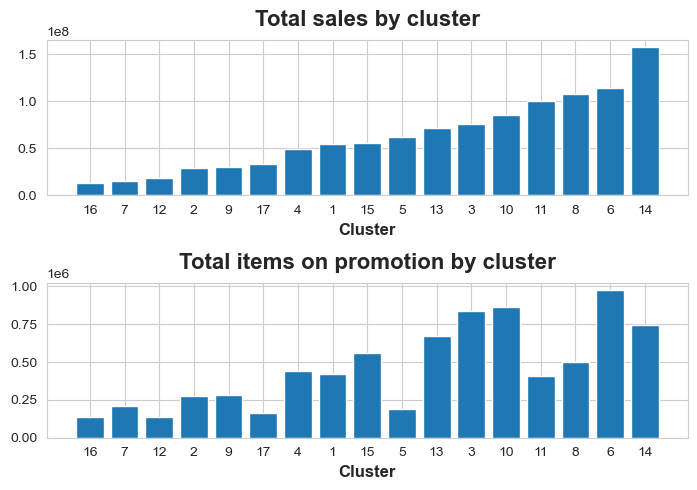

In [79]:
ts = train[['store_nbr','onpromotion','sales']].merge(stores[['cluster','type']],'left',right_index=True,left_on='store_nbr')
ts['cluster'] = ts['cluster'].astype('category')
ts = (ts.groupby('cluster')[['onpromotion','sales']]
 .sum()
 .sort_values('sales')
 .reset_index()
)

fig,(ax1,ax2) = plt.subplots(figsize=(7,5), nrows=2)

ax1.bar(
    # matplotlib DOES NOT recognize pandas categorical types!!!
    x=ts['cluster'].astype(str),
    height=ts['sales']
)
ax1.set_title('Total sales by cluster')
ax1.set_xlabel('Cluster')

ax2.bar(
    # matplotlib DOES NOT recognize pandas categorical types!!!
    x=ts['cluster'].astype(str),
    height=ts['onpromotion']
)
ax2.set_title('Total items on promotion by cluster')
ax2.set_xlabel('Cluster')
plt.show()

C:\Users\jesse\AppData\Local\Temp\ipykernel_17968\1589999736.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ts = (ts.groupby('type')[['onpromotion','sales']]


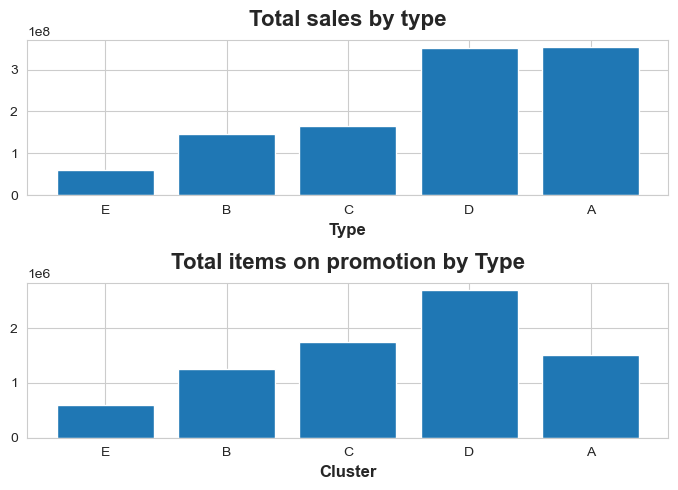

In [80]:
ts = train[['store_nbr','onpromotion','sales']].merge(stores[['cluster','type']],'left',right_index=True,left_on='store_nbr')
ts['type'] = ts['type'].astype('category')
ts = (ts.groupby('type')[['onpromotion','sales']]
 .sum()
 .sort_values('sales')
 .reset_index()
)

fig,(ax1,ax2) = plt.subplots(figsize=(7,5),nrows=2,)

ax1.bar(
    # matplotlib DOES NOT recognize pandas categorical types!!!
    x=ts['type'].astype(str),
    height=ts['sales']
)
ax1.set_title('Total sales by type')
ax1.set_xlabel('Type')

ax2.bar(
    # matplotlib DOES NOT recognize pandas categorical types!!!
    x=ts['type'].astype(str),
    height=ts['onpromotion']
)
ax2.set_title('Total items on promotion by Type')
ax2.set_xlabel('Cluster')
plt.show()

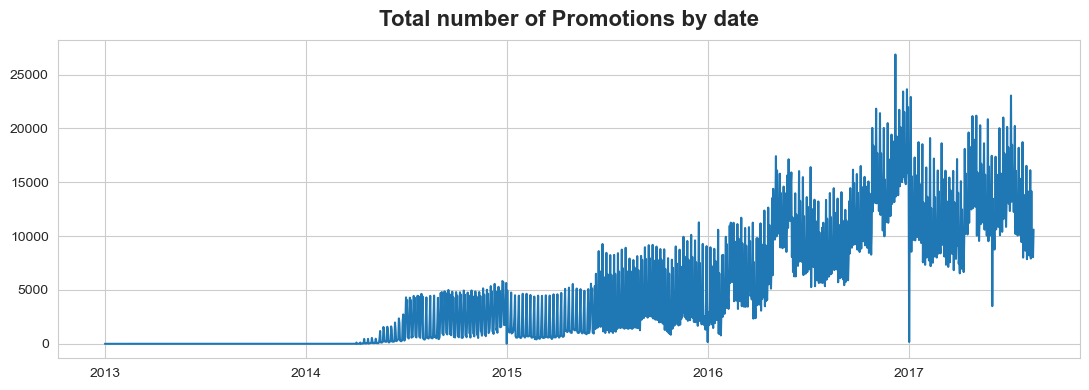

In [81]:
# plotting promotions over time
fig,ax=plt.subplots()

ax.plot(
    'date',
    'onpromotion',
    data=train.pivot_table(values='onpromotion',index='date',aggfunc='sum').reset_index()
)
ax.set_title('Total number of Promotions by date')
plt.show()

In [82]:
from sklearn.preprocessing import StandardScaler

t = train.pivot_table(values=['onpromotion','sales'],index='date',aggfunc='sum').reset_index()
t[['onpromotion','sales']] = StandardScaler().fit_transform(t[['onpromotion','sales']])

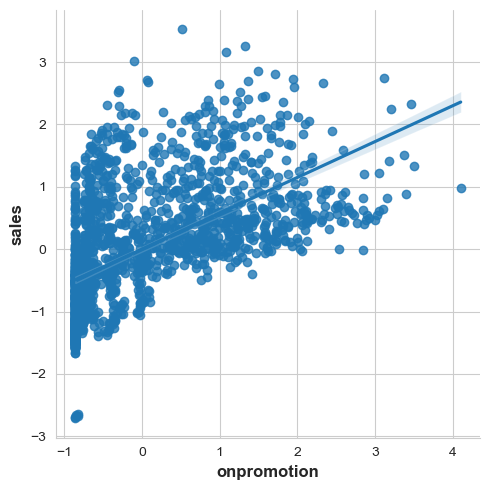

In [83]:
sns.lmplot(
    data=t,
    x='onpromotion',
    y='sales'
)
plt.show()

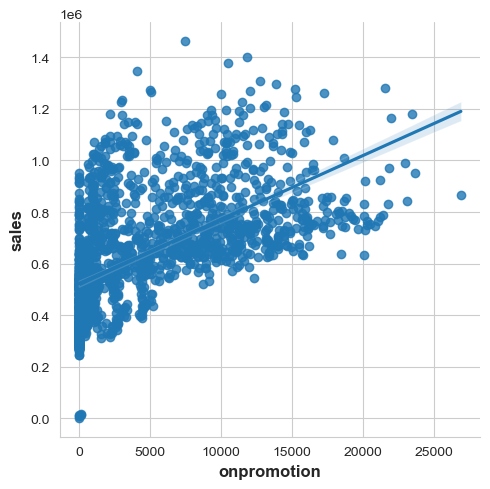

In [84]:
sns.lmplot(
    data=train.pivot_table(values=['onpromotion','sales'],index='date',aggfunc='sum').reset_index(),
    x='onpromotion',
    y='sales'
)
plt.show()

## univariate visualization

### Geography table

In [85]:
stores[~stores[['city','state']].duplicated()][['city','state']]

,city,state
store_nbr,,
1,Quito,Pichincha
5,Santo Domingo,Santo Domingo de los Tsachilas
11,Cayambe,Pichincha
12,Latacunga,Cotopaxi
14,Riobamba,Chimborazo
15,Ibarra,Imbabura
19,Guaranda,Bolivar
22,Puyo,Pastaza
23,Ambato,Tungurahua


In [86]:
stores_geography = pd.read_csv(
    "store_sales_data/stores_geography.csv",
)
stores_geography.head()

,country,state,city,latitude,longitude
0,Ecuador,Pichincha,Quito,-0.180653,-78.467838
1,Ecuador,Santo Domingo de los Tsachilas,Santo Domingo,-0.238904,-79.177427
2,Ecuador,Pichincha,Cayambe,0.031957,-78.150742
3,Ecuador,Cotopaxi,Latacunga,-0.931556,-78.605850
4,Ecuador,Chimborazo,Riobamba,-1.663551,-78.654646


From the internet, I filled in the geographic information into a new table.

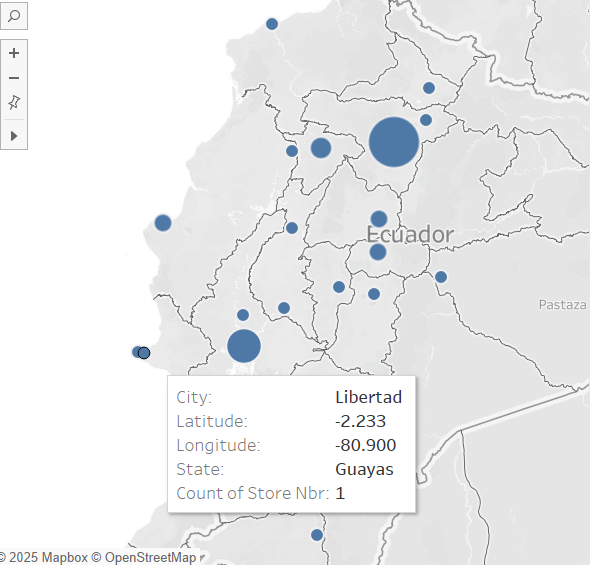

Also, Libertad is in Santa Elena, NOT Guayas. I made the appropriate augmentation in the `store_geography` table.

In [87]:
stores_geography[stores_geography.city=='Libertad']

,country,state,city,latitude,longitude
15,Ecuador,Santa Elena,Libertad,-2.2333,-80.9


In [88]:
stores[stores.city=='Libertad']

,city,state,type,cluster
store_nbr,,,,
36,Libertad,Guayas,E,10


In [89]:
# What does sale mean? Price? Quantity?

# Could I add another thing, like region, to stores table for lower level granularity? (Maybe for Augmentation phase)

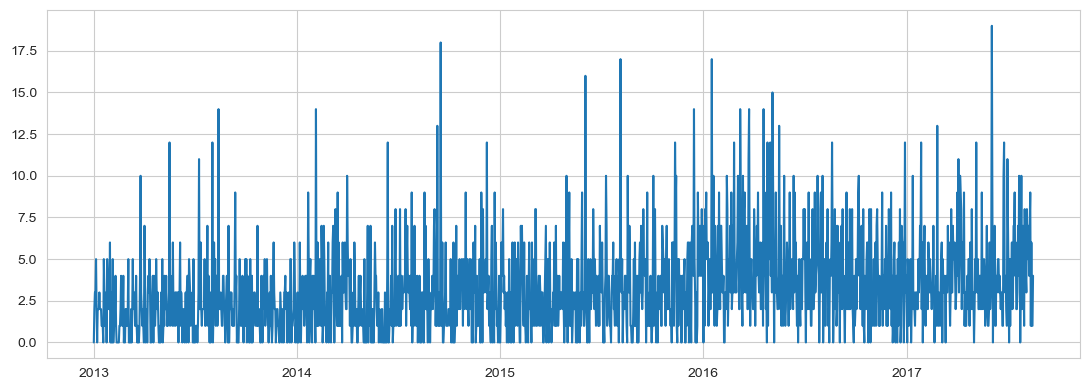

In [90]:
mask = train[(train["store_nbr"]==1) & (train["family"]=="AUTOMOTIVE")]
y = mask["sales"]
x = mask["date"]
plt.plot(x,y)

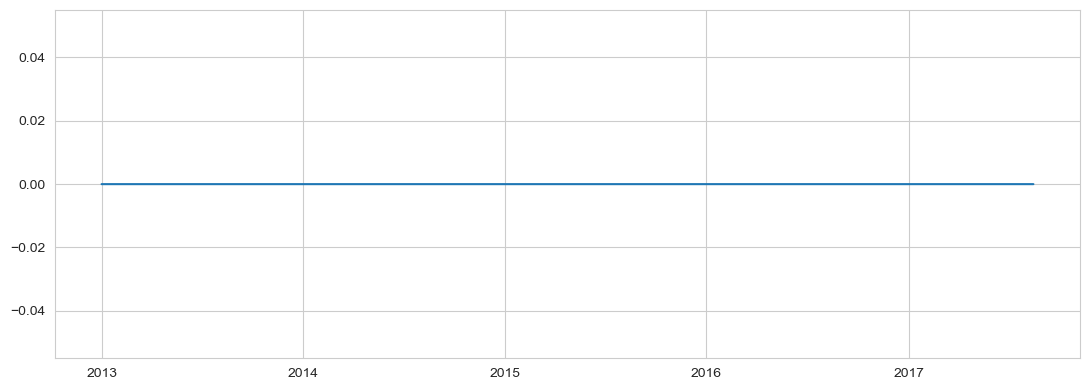

In [91]:
mask = train[(train["store_nbr"]==45) & (train["family"]=="BABY CARE")]
y = mask["sales"]
x = mask["date"]
plt.plot(x,y)

In [92]:
train[train['date']=='2013-01-01']

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...
1777,2013-01-01,9,POULTRY,0.0,0
1778,2013-01-01,9,PREPARED FOODS,0.0,0
1779,2013-01-01,9,PRODUCE,0.0,0


In [93]:
holidays_events[holidays_events['date']>'2012-12-31'].head()

,date,type,locale,locale_name,description,transferred
41,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
44,2013-02-11,Holiday,National,Ecuador,Carnaval,False
45,2013-02-12,Holiday,National,Ecuador,Carnaval,False


There are 7,128 missing... where are these records located?? There's no missing values in `train`

In [94]:
## There are some stores that never sold an item in a certain category. Should we find them?

for category in train['family'].unique():
    print(category)

AUTOMOTIVE
BABY CARE
BEAUTY
BEVERAGES
BOOKS
BREAD/BAKERY
CELEBRATION
CLEANING
DAIRY
DELI
EGGS
FROZEN FOODS
GROCERY I
GROCERY II
HARDWARE
HOME AND KITCHEN I
HOME AND KITCHEN II
HOME APPLIANCES
HOME CARE
LADIESWEAR
LAWN AND GARDEN
LINGERIE
LIQUOR,WINE,BEER
MAGAZINES
MEATS
PERSONAL CARE
PET SUPPLIES
PLAYERS AND ELECTRONICS
POULTRY
PREPARED FOODS
PRODUCE
SCHOOL AND OFFICE SUPPLIES
SEAFOOD


There are sooo many products. What if I just focused on the top 10 for my report??

### Creating dates table

In [95]:
date_range = pd.date_range(start="2012-12-30", end="2017-09-01", freq="D")

dates = pd.DataFrame({
    "date": date_range,
    "year": date_range.year,
    "month": date_range.month,
    "day": date_range.day,
    "weekday": date_range.weekday,
    "quarter": date_range.quarter,
    "is_weekend": date_range.weekday >= 5
})

dates.set_index("date", inplace=True)

In [96]:
dates.head(3)

,year,month,day,weekday,quarter,is_weekend
date,,,,,,
2012-12-30,2012,12,30,6,4,True
2012-12-31,2012,12,31,0,4,False
2013-01-01,2013,1,1,1,1,False
